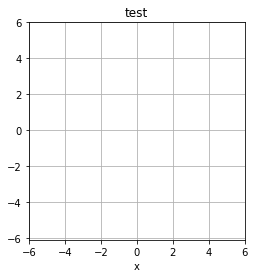

In [6]:
#author:  Tsiapras Tilemachos
#date:    Jun/ 11/ 2019
#version: 3

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math as m
import numpy as np
import time
import pandas as pd


############ IMPORTATION OF DATA #############
# importing files containning the angle of joint through 
# time(% of movement) for the Hip and the Knee
# the data form is an 100 size array
kneeData = pd.read_excel("Knee.xlsx")
hipData = pd.read_excel("Hip.xlsx")

# converting to np.array
KneeAngle = np.array(kneeData)
HipAngle = np.array(hipData) -13# -15 for adjustng for the posture of the subject

# converting to RAD
for i in range(KneeAngle.shape[0]):
	KneeAngle[i][0] = m.radians(KneeAngle[i][0])
	HipAngle[i][0] = m.radians(HipAngle[i][0])


############ VARIABLES INSTATIATION #############
#< Length of diferent parts of the leg >#
Lh = 3 #hip to knee
Lk = 3 #knee to ankle
Lf = 0.6 #ankle to toes

#< Point calculate for the Diagramm Animation >#
#P  = [X,Y]
Ph  = [0,0] #the Hip
Pk  = [0,0] #the Knee
Pa  = [0,0] #the Ankle
Pt  = [0,0] #the Toes

#< Matrix used in the update function during the animation>#
data = np.array([[[float(0)]*4]*2]*99)

dy = [] # express the vertical movement of the whole system(Figure) due to the foot's stiffness


############ POINTS ROUTINES #############
#< Set of Routines to calculate the points >#
#<     from the leg's relative angles      >#
def get_Pk(Lh, Wh):
	X = m.sin(Wh)*Lh
	Y = m.cos(Wh)*Lh
	return([X,-Y])

def get_Pa(Lk, Wh, Wk, Pk):
	X = Pk[0] + m.sin(Wh - Wk) * Lk
	Y = Pk[1] - m.cos(Wh - Wk) * Lk
	return([X,Y])

def get_Pt(Lf, Wh, Wk, Pa):
	X = Pa[0] + m.cos(Wk - Wh) * Lf
	Y = Pa[1] - m.sin(Wk - Wh) * Lf
	return([X,Y])

def get_Dy(Ya, Yt, Yf_, Yt_):
	return(min(Ya, Yt, Yf_, Yt_)+Lh+Lk)


############ ANIMATION POINTS CALCULATION #############
#  Calculation o the points  #
# for 99 clicks of the gait. #
for i in range(99):
	Pk  = get_Pk(Lh, HipAngle[i][0])
	Pa  = get_Pa(Lk, HipAngle[i][0], KneeAngle[i][0], Pk)
	Pt  = get_Pt(Lf, HipAngle[i][0], KneeAngle[i][0], Pa)

	data[i][0][0],data[i][1][0] = Ph
	data[i][0][1],data[i][1][1] = Pk
	data[i][0][2],data[i][1][2] = Pa
	data[i][0][3],data[i][1][3] = Pt

#< Calculating Dy for each frame >#
for i in range(99):
	dy.append(get_Dy(data[i][1][2],data[i][1][3],data[(i+50)%99][1][2],data[(i+50)%99][1][3]))

#< Updating the y values of each point >#
for i in range(99):
	data[i][0][0],data[i][1][0] = [data[i][0][0],data[i][1][0]-dy[i]]
	data[i][0][1],data[i][1][1] = [data[i][0][1],data[i][1][1]-dy[i]]
	data[i][0][2],data[i][1][2] = [data[i][0][2],data[i][1][2]-dy[i]]
	data[i][0][3],data[i][1][3] = [data[i][0][3],data[i][1][3]-dy[i]]


############ ANIMATION ROUTINES AND DRAWING #############
speed = 30 # speed of animation's Iteration delay (higher => slower movement)

fig1 = plt.figure()
line, = plt.plot([], [])
plt.grid(True)

# Setting the two legs
plotlays, plotcols = [4], ["blue","red","blue","green"]
lines = []

# creating Line Objects
for index in range(4):
	lobj = plt.plot([],[],lw=3,color=plotcols[index])[0]
	lines.append(lobj)

# creating Dot Objects
lobj = plt.plot([],[],'o', markersize =8,color="black")[0]
lines.append(lobj)

plt.ylim(-6.1, 6)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal', adjustable='box') #corrects the scale of X and Y axis
plt.xlabel('x')
plt.title('test')

def init():
	for line in lines:
		line.set_data([],[])
	return lines
	
def update_line(num):

	for lnum,line in enumerate(lines):
		num_ = ((num+50)%99)
		if(lnum == 0):
			# subject's blue leg
			line.set_data(data[num,..., :])
		elif(lnum == 1):
			# subject's red leg
		    line.set_data(data[num_,..., :])
		elif(lnum == 2):
			# subject's blue "body" line
			line.set_data([[0,0.2],[0-dy[num],4-dy[num]]])
		elif(lnum == 3):
			# green line for the ground feel
			line.set_data([[-10,10],[-Lk -Lh -0.05,-Lk -Lh -0.05]])
		elif(lnum == 4):
			# black cyrcles representing the actuators
			line.set_data([[data[num,0, 0],data[num,0, 1],data[num_,0, 1]],[data[num,1, 0],data[num,1, 1],data[num_,1, 1]]])

	return lines

ani = animation.FuncAnimation(fig1, update_line,init_func=init, frames = 99, interval=speed, blit=True)

plt.show()
